# A Kalman Filter for Estimating Covid19 Status in San Diego County

## Introduction

A [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter) is an algorithm that uses a Bayesian probability model to refine the estimate of a system state variable.  By combining what is known about the error in the measurement with what is known about the statistical parameters of the process or system evolution, a better estimate of the system's state can be obtained than could otherwise be obtained by relying on the measurement or the process parameters alone.  A Kalman Filter is also a causal estimator -- meaning that the current estimate depends only on past and preset estimates.  

In this notebook, I use a Kalman Filter to try to estimate the state of new Covid19 infections in San Diego County.  Specifically, I attempt to find a model to estimate the **number of new cases per day** and the **rate of change of new cases per day**.  The Kalman Filter used is of the most rudimentary type: a nearly constant velocity (NCV) filter assuming Gaussian distributions for the measurement error and process noise.  The Kalman Filter model seems to do a much better job than a least squares fit at tracking the reported number of new cases per day of Covid19.

## Comparison to Linear Least-Squares Estimators 

In a [previous blog post](http://jendobson.com/2020/06/30/covid19-in-san-diego-county-tracking-changes-in-the-daily-rate-of-increase/), I tried to build understanding of the state of Covid19 in San Diego county by performing a linear least-squares fit to the most recent 14 days of data in order to understand the general trajectory of new cases per day both county-wide and by zipcode.  Generally, positive linear coefficients indicated that the number of new cases per day was increasing and negative linear coefficients indicated wthat the number of new cases per day was decreasing.  

The problem with this approach is that the 14-day, windowed LLSQ fit is very sensitive to choice of "the most recent data": pick a window too small, and the fit is extremely sensitive to day-to-day variation in case counts (i.e. noise); pick a window too large, and the fit does not capture sudden changes in the processes (i.e a sudden acceleration in new cases per day).  Certainly there are remedies that could be tried -- a quadratic or exponential growth model for the fit could be used, for example.  However I wanted to remain as agnostic as possible on defining a model for disease evolution.  Though traditional SIR and SEIR models suggest an exponential fit would be correct, these models do not take into account the daily change in levels of public activity (i.e. social distancing, business closures, mask wearing) or changes in testing capacity or policy.

## Kalman Filter Overview

The first step in implementing a Kalman Filter is to define a state in a system.  The state is represented as a vector $\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}$.  For the problem of estimating Covid19 infection rates, the first element of the vector state, $ x $, is the number of new reported cases per day.  The second element, $ \dot x $ is the rate of change of number of new cases per day.  Our system model says that every day the new value of $ x $ is determined by yesterday's value of $ x $ plus yesterday's value of $ \dot x $ multiplied by the time elapsed (1 day).  Also, we assume the rate of change of cases is relatively constant.  In other words:

$$
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
$$

So everyday, we use today's estimate of the state (i.e. what we believe to be the current number of new cases per day and the rate-of-change or new cases per day) to predict tomorrow's new cases per day.  Then when tomorrow happens, we compare what we predicted as the number of new cases per day with actual measured number of cases per day.  The two values won't be the same, as there is variance in our process model and noise in our measurement.  But by comparing what we think the state should be with what we measure it to be, we can obtain a more reliable estimate of the state that what we could have obtained from just the process model or just the measurement alone.

## Estimating New Reported Cases Per Day, $ x $

The plot below shows the Kalman Filter estimate of number of new cases per day (i.e. $ x $), along with the 1 standard-deviation upper and lower bounds on the estimate.  For comparison, the estimates of $ x $ using a rolling, linear least-squares fit using 4-day, 7-day, and 14-day windows are also shown.  Note that for the LLSQ fits the constant term, c0, obtained from the fit is plotted.  The linear term, c1, will be used in the next section when we attempt to estimate the rate of change of new cases per day.  

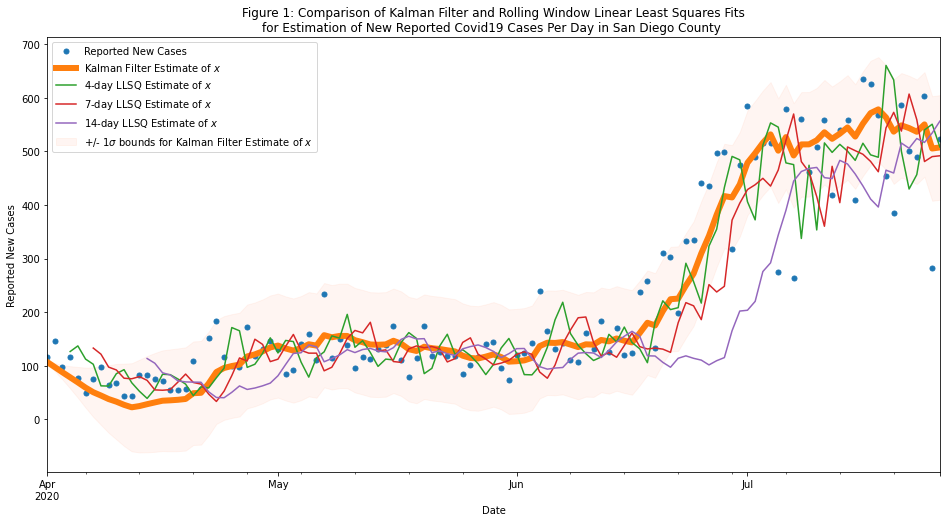

In [144]:
import notebook_helpers as nh
import pandas as pd

sddata = nh.load_data(nh.CSVFILEPATH)
# Find a baseline "quiet period variance" for scaling the measurement noise variance 
qpv = sddata['TOTAL'].iloc[(sddata.index>=pd.Timestamp(2020,5,1))&(sddata.index<=pd.Timestamp(2020,5,31))].var() 

(estimate_df,f) = nh.kf(sddata['TOTAL'],50*qpv,20)
(fig,ax) = nh.plot_figure1(estimate_df)

As can be seen, the Kalman filter estimate of new cases per day responds quickly to changes in the process (an uptick in the underlying rate in new cases per day) but also remains relatively stable despite wide day-to-day swings in actual case counts due to random variation.   

## Estimating Rate-of-Change of New Reported Cases Per Day, $ \dot x $

The Kalman Filter again outperforms LLSQ estimates when estimating how the number of new reported cases per day is changing.  The Kalman Filter gives a more stable rate-of-change estimate than the 4-day and 7-day LLSQ windows.  The 14-day LLSQ rate-of-change estimate seems comparable to the Kalman Filter rate-of-change estimate, but that is at the cost of slow response to changes in the underlying process as seen in the 14-day windowed estimates of $ x $ in the figure above.

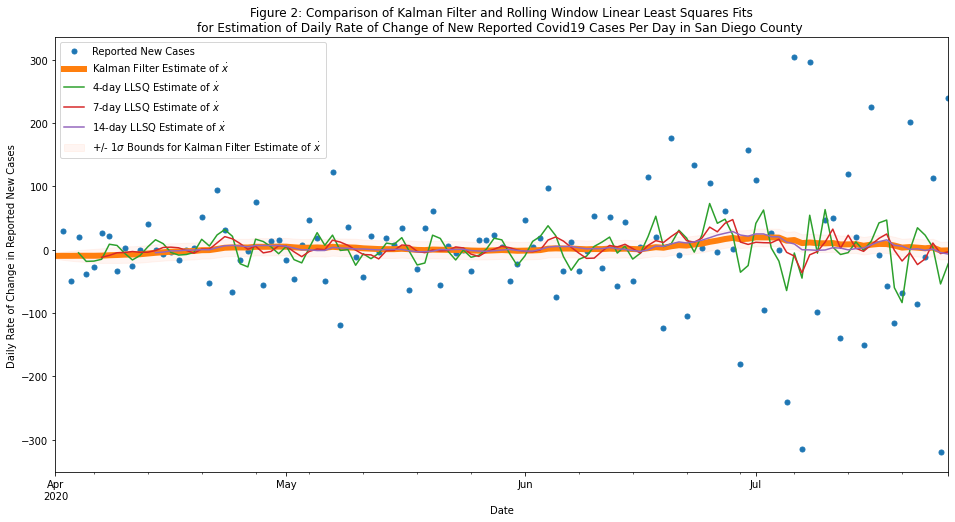

In [145]:
(fig,ax) = nh.plot_figure2(estimate_df)

We can look a more closely at the Kalman Filter estimate for rate-of-change of new cases per day to study the trend in more detail.  The plot in figure 3 below contains data through July 26, 2020.  From figure 1, the number of new cases per day reported in San Diego County remained quite high hovering around 500 during the month of July.  However the Kalman estimate for *rate of change* in new cases per day has been decreasing by about 0.5 cases per day.  Though it will take some time for the reported number of new cases per day to drop from 500 down to zero, if the current trend continues, we should at least see a modest decrease in the number of new cases per day through the month of August.

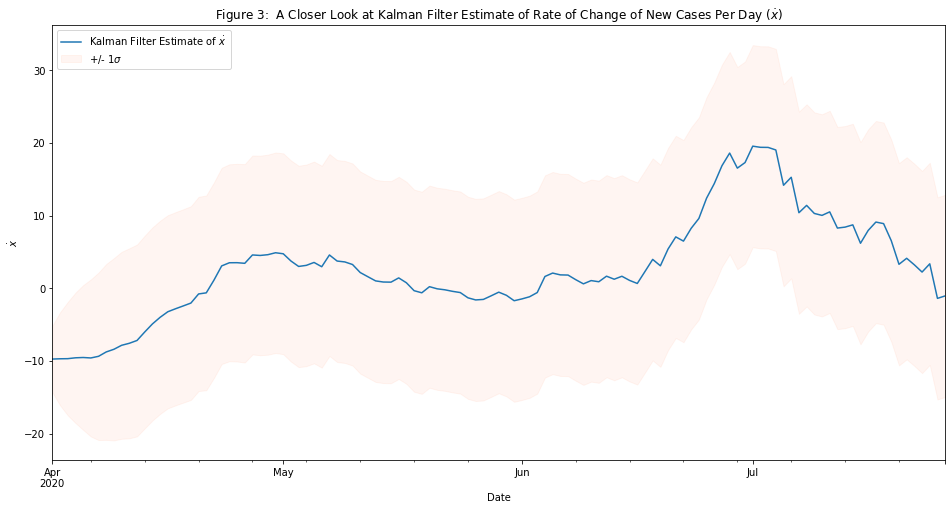

In [147]:
(fig,ax) = nh.plot_figure3(estimate_df)

## Acknowledgements

Roger Labbe has written a [gentle, programming-based introduction to Kalman and Bayesian Filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python).  I highly recommend his book.  He is also the author of the open source python package [filterpy](https://filterpy.readthedocs.io/en/latest/), which I used to build the Kalman Filters in this analysis.

Pete Mayer is always a source of inspiring conversations and technical guidance.